# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
#Se importan librerias necesarias 
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [3]:
#Se carga el DataFrame 
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [4]:
#Se imprime el head del DataFrame
print(df_reviews.head(5))

      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage impl

In [5]:
#Se imprime la informacion del DataFrame
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

##### No existen valores nulos, asi que podemos continuar con el analisis

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

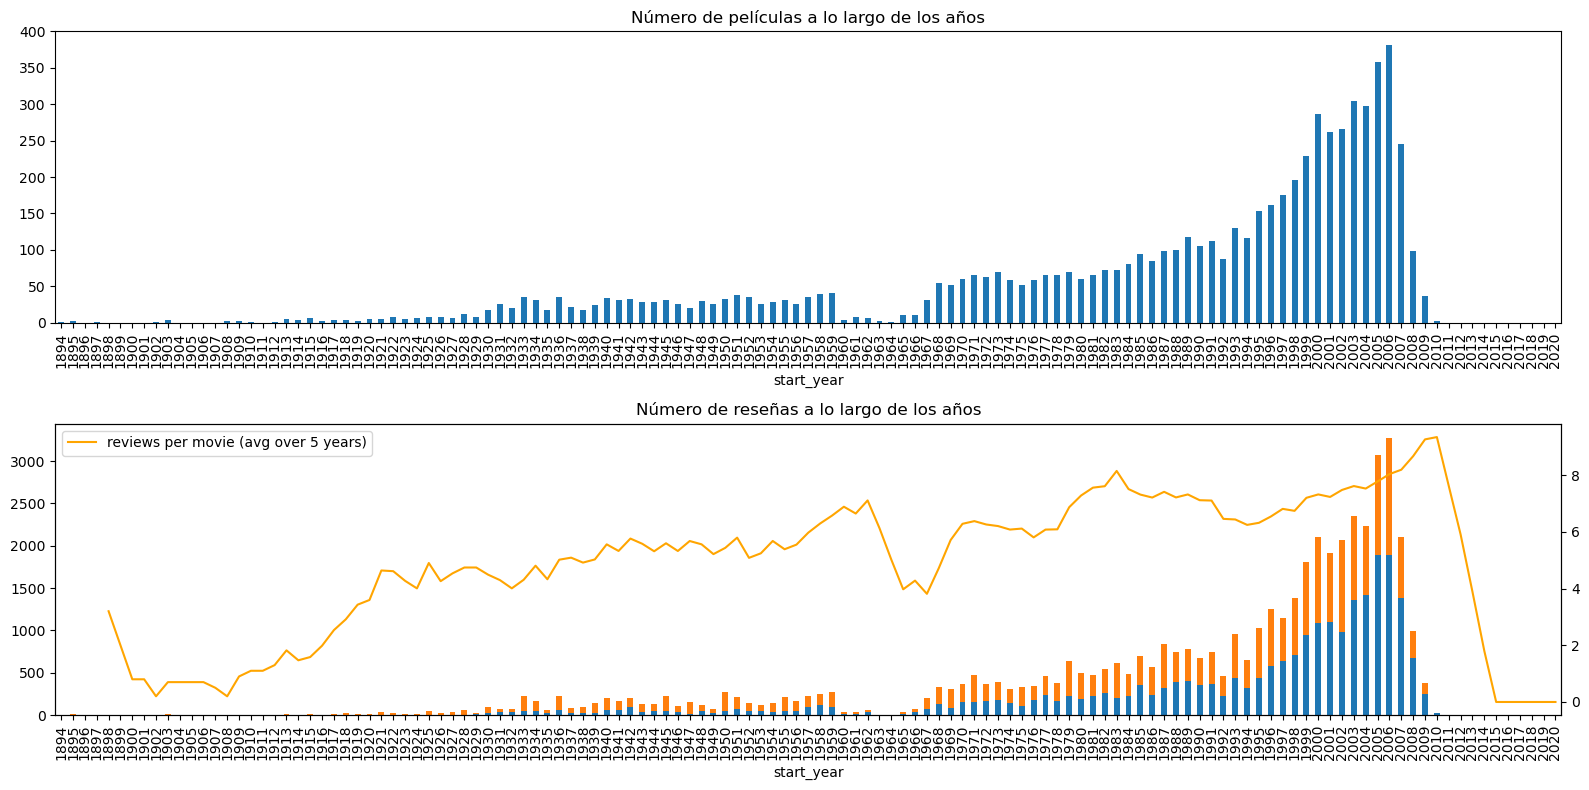

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

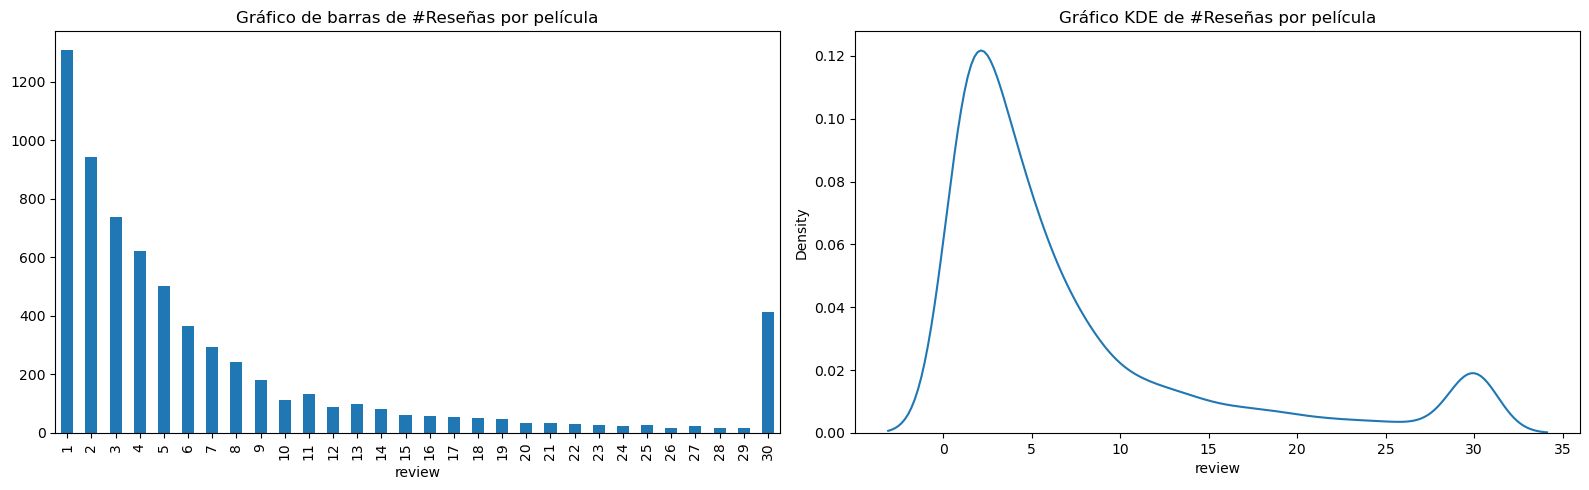

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [8]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

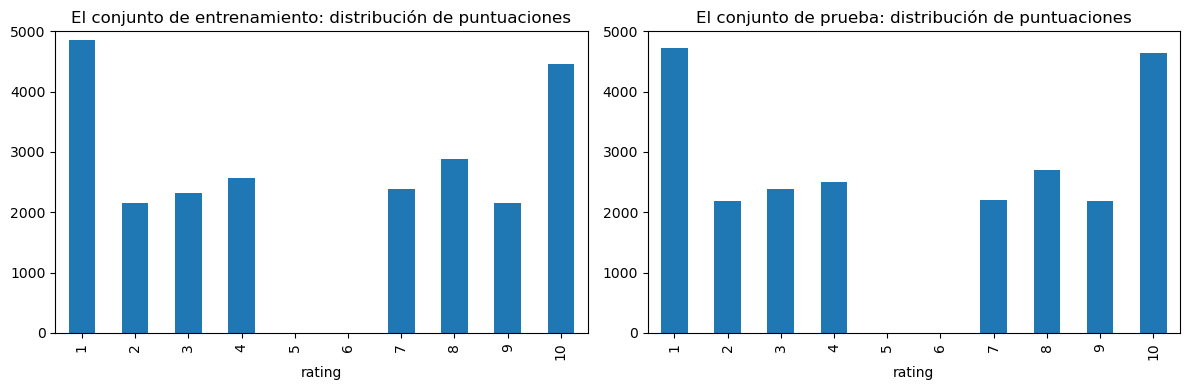

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/var/folders/tl/svswzrd161q7xy22grsvz20h0000gn/T/ipykernel_6808/1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/var/folders/tl/svswzrd161q7xy22grsvz20h0000gn/T/ipykernel_6808/1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
/var/folders/tl/svswzrd161q7xy22grsvz20h0000gn/T/ipykernel_6808/1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/var/folders/tl/svswzrd161q7xy22grsvz20h0000gn/T/ipyke

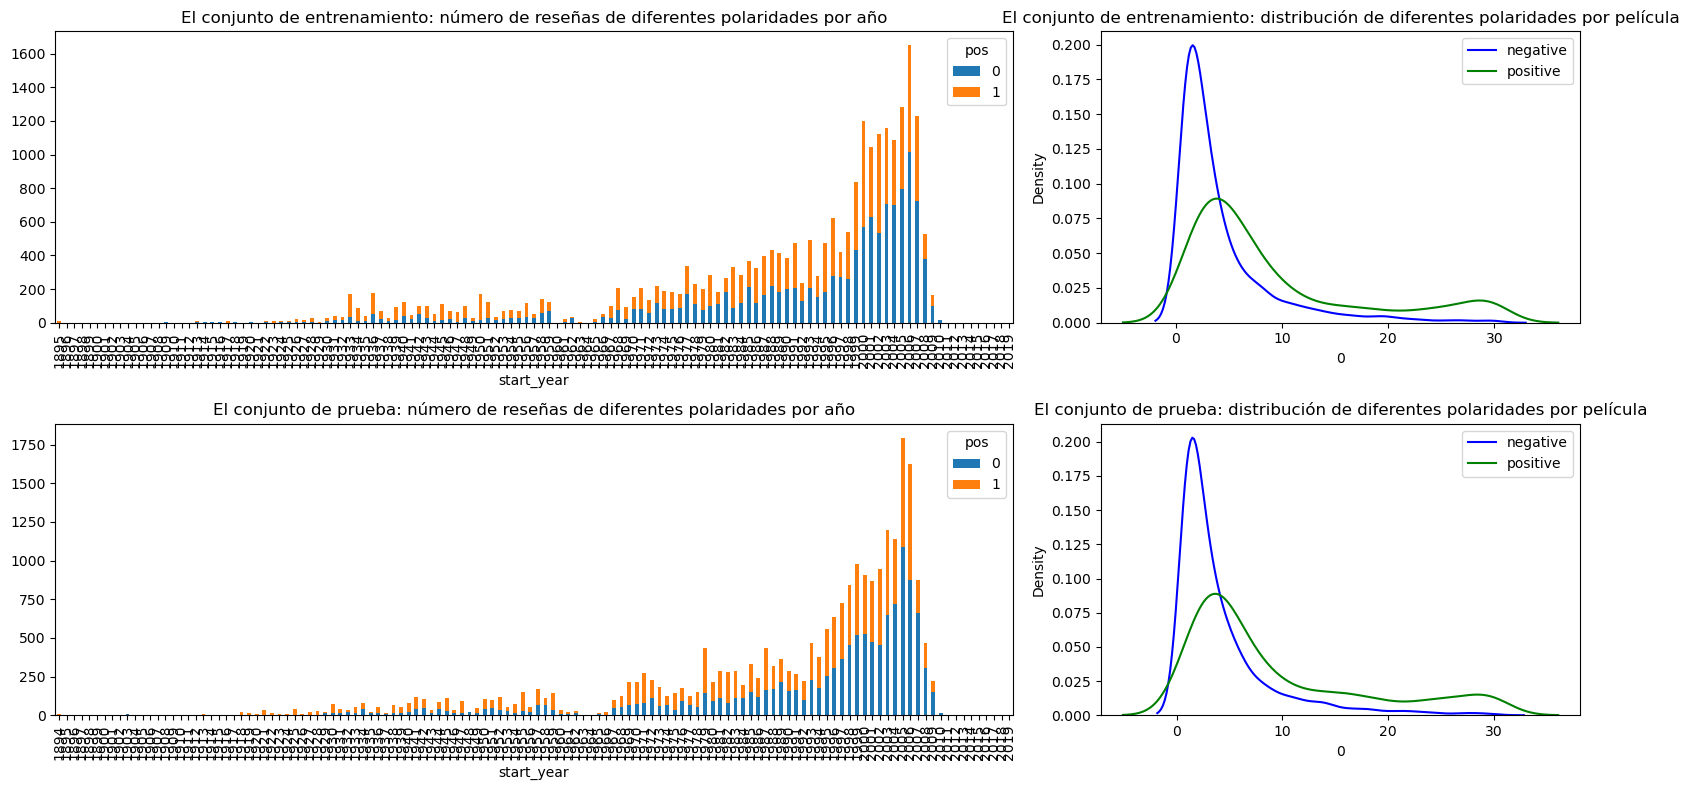

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [11]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [12]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('^a-zA-Z', ' ')

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [13]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 1 - Constante

In [14]:
from sklearn.dummy import DummyClassifier

In [15]:
dummy_model = DummyClassifier(strategy='constant', constant=1)

In [16]:
model_1 = dummy_model.fit(X=df_reviews_train, y=train_target)

           train  test
Exactitud    NaN   NaN
F1          0.67  0.67
APS         0.50  0.50
ROC AUC     0.50  0.50


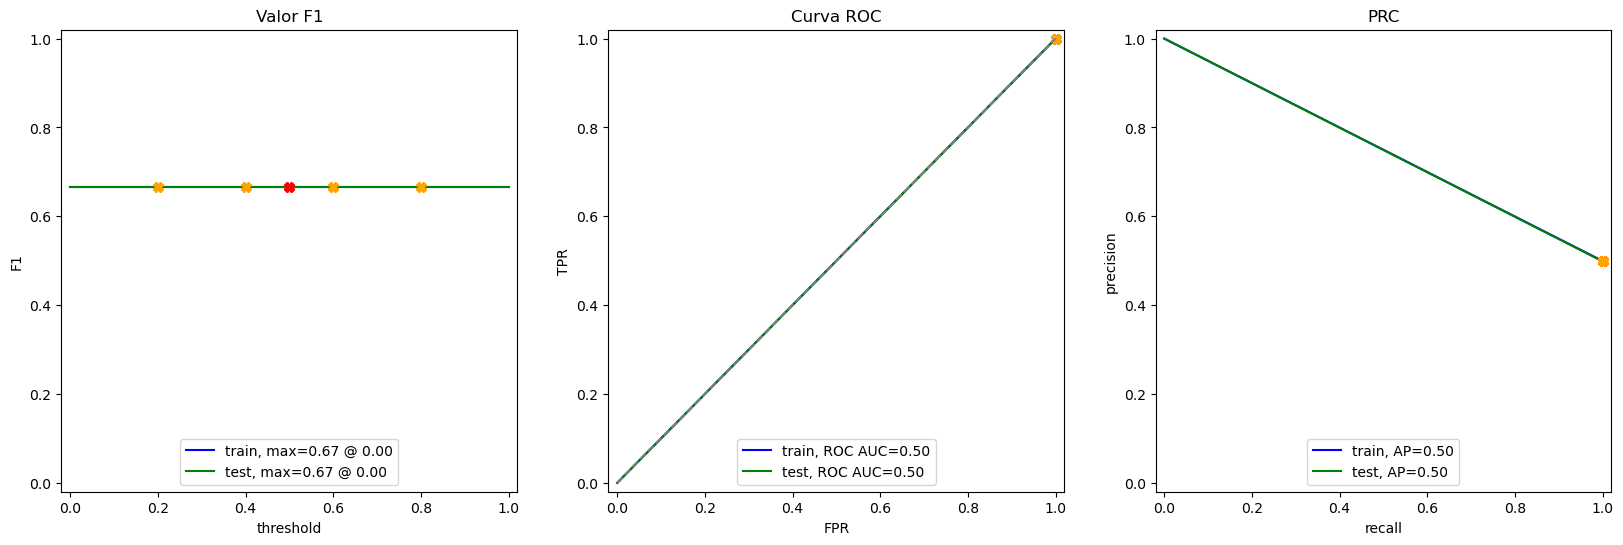

In [17]:
evaluate_model(model_1, df_reviews_train, train_target, df_reviews_test, test_target)

##### El valor de F1 nos indica que este modelo tiene un desempeño moderado, pero no es aceptado para propositos del proyectos.

##### El APS mide la precision promedio ponderada para diferentes umbrales de clasificacion, un valor de 0.50 nos indica que el modelo se encuentra adivinando de manera aleatoria.

##### El ROC AUC mide la capacidad del modelo de distinguir entre clases, un valor de 0.50 significa que el modelo no tiene habilidad discriminatoria y esta clasificando al azar.

### Modelo 2 - NLTK, TF-IDF y LR

TF-IDF

In [24]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/gabo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [111]:
tfidf_vectorizer_2 = TfidfVectorizer(stop_words='english', lowercase=True)
tf_idf_train = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm'])

In [112]:
print(tf_idf_train.shape)

(23796, 72915)


In [113]:
tf_idf_test = vectorizer.transform(df_reviews_test['review_norm'])

In [114]:
print(tf_idf_test.shape)

(23535, 72915)


In [115]:
model_2 = LogisticRegression()
model_2.fit(tf_idf_train, train_target)

LogisticRegression()

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


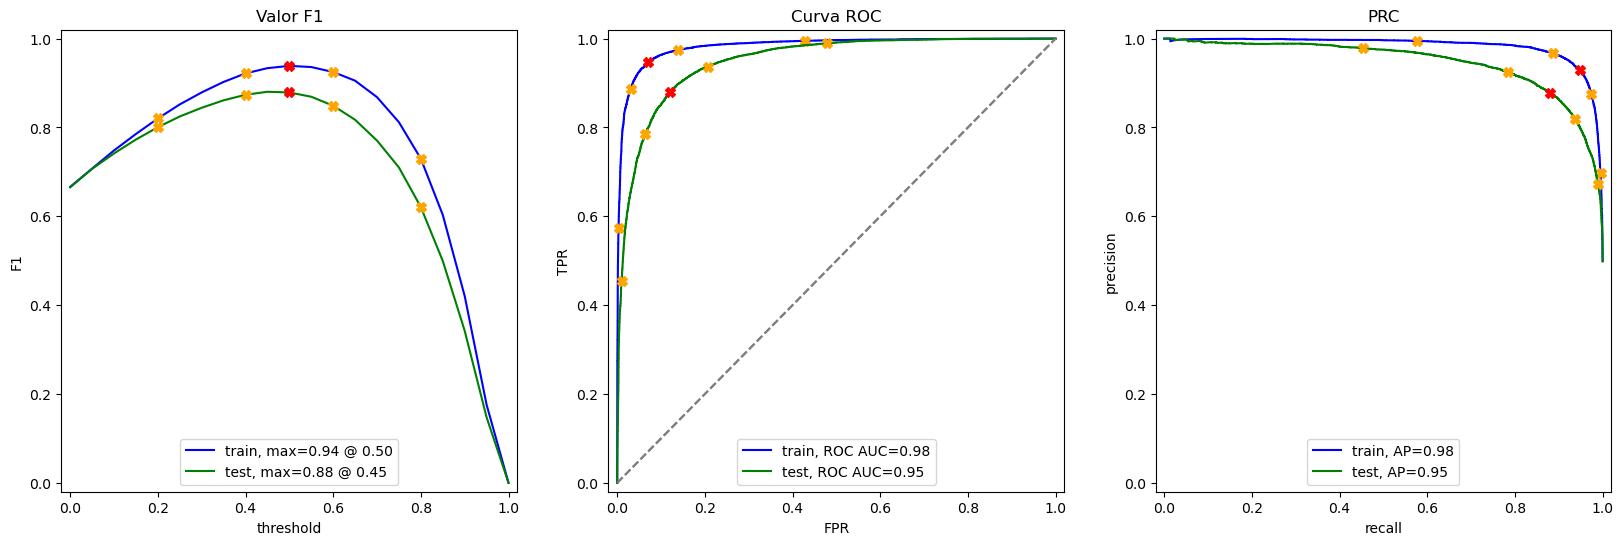

In [116]:
evaluate_model(model_2, tf_idf_train, train_target, tf_idf_test, test_target)

##### El F1 score nos indica que el conjunto de entrenamiento esta clasificando muy bien, el de prueba tiene un desempeño menor pero igualmente es un buen valor de desempeño.

##### Los valores cercanos a 1 del APS suguieren que el modelo predice con alta confianza.

##### Los valores cercanos a 1 del ROC AUC indican una excelente discriminacion.

### Modelo 3 - spaCy, TF-IDF y LR

In [74]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [76]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)



In [78]:
df_reviews_train['review_tokens'] = df_reviews_train['review_norm'].progress_apply(lambda review : text_preprocessing_3(review))

  0%|          | 0/23796 [00:00<?, ?it/s]

In [79]:
df_reviews_test['review_tokens'] = df_reviews_test['review_norm'].progress_apply(lambda review : text_preprocessing_3(review))

  0%|          | 0/23535 [00:00<?, ?it/s]

In [80]:
vectorizer_3 = TfidfVectorizer()

In [93]:
train_features_3 = vectorizer_3.fit_transform(df_reviews_train['review_tokens'])
print(train_features_3.shape)

(23796, 61378)


In [94]:
test_feature_3 = vectorizer_3.transform(df_reviews_test['review_tokens'])
print(test_feature_3.shape)

(23535, 61378)


In [95]:
model_3 = LogisticRegression(max_iter = 1000000000)

In [96]:
model_3.fit(train_features_3, train_target)

LogisticRegression(max_iter=1000000000)

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


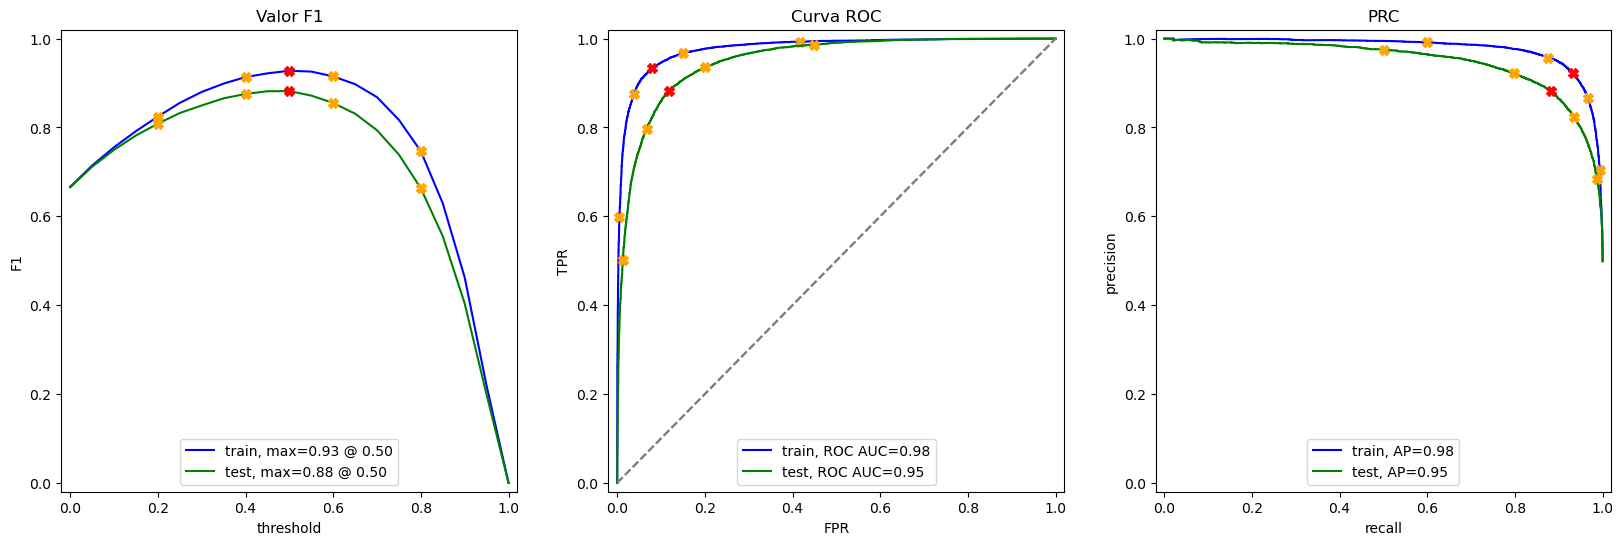

In [98]:
evaluate_model(model_3, train_features_3, train_target, test_feature_3, test_target)

##### El F1 score nos indica que el conjunto de entrenamiento esta clasificando muy bien, el de prueba tiene un desempeño menor pero igualmente es un buen valor de desempeño.

##### Los valores cercanos a 1 del APS suguieren que el modelo predice con alta confianza.

##### Los valores cercanos a 1 del ROC AUC indican una excelente discriminacion.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [99]:
from lightgbm import LGBMClassifier

In [103]:
model_4 = LGBMClassifier(learning_rate=0.01)

In [104]:
model_4.fit(train_features_3, train_target)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.752021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 486676
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9650
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMClassifier(learning_rate=0.01)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


           train  test
Exactitud    NaN   NaN
F1          0.80  0.79
APS         0.87  0.86
ROC AUC     0.87  0.86


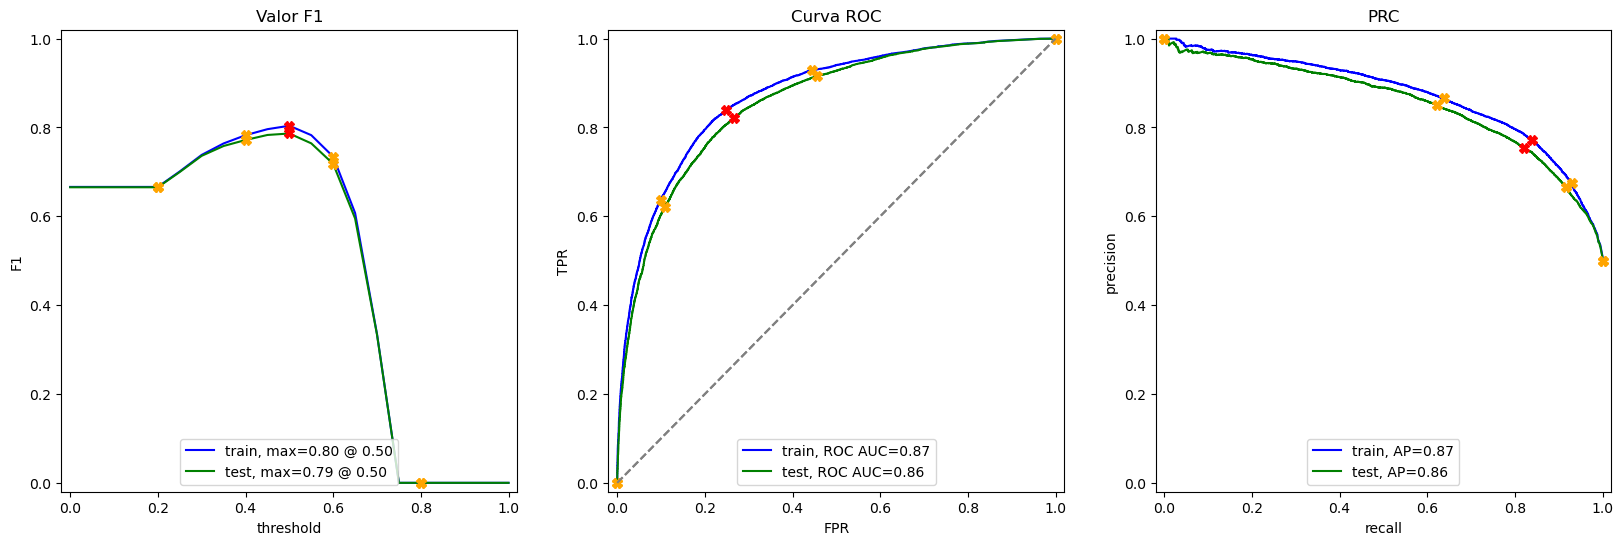

In [105]:
evaluate_model(model_4, train_features_3, train_target, test_feature_3, test_target)

##### El F1 score nos indica que el conjunto de entrenamiento esta clasificando ligeramente bien, el de prueba tiene un desempeño menor pero no cumple lo que nos pide el proyecto.

##### Los valores del APS estan cerca del 1 suguieren que el modelo predice con una buena confianza.

##### Los valores cercanos a 1 del ROC AUC indican una buena discriminacion.

## Mis reseñas

In [130]:

# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace('^[a-zA-Z]', " ")

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.","i did not simply like it, not my kind of movie."
1,"Well, I was bored and felt asleep in the middl...","well, i was bored and felt asleep in the middl..."
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good! writ...
5,"The movie had its upsides and downsides, but I...","the movie had its upsides and downsides, but i..."
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy. not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move & i real...


### Modelo 2

In [131]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.09:  i did not simply like it, not my kind of movie.
0.06:  well, i was bored and felt asleep in the middle of the movie.
0.56:  i was really fascinated with the movie
0.18:  even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.24:  i didn't expect the reboot to be so good! writers really cared about the source material
0.42:  the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.04:  what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.88:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


### Modelo 3

In [132]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it, not my kind of movie.
0.23:  well, i was bored and felt asleep in the middle of the movie.
0.59:  i was really fascinated with the movie
0.18:  even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.20:  i didn't expect the reboot to be so good! writers really cared about the source material
0.68:  the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.03:  what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.87:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


### Modelo 4

In [133]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.51:  i did not simply like it, not my kind of movie.
0.63:  well, i was bored and felt asleep in the middle of the movie.
0.62:  i was really fascinated with the movie
0.67:  even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.55:  i didn't expect the reboot to be so good! writers really cared about the source material
0.63:  the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.52:  what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.62:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Conclusiones

##### El mejor modelo en relacion resultados y tiempo es el modelo numero 2 NLTK, TF-IDF y LR, podemos comprobar esto con sus excelentes metricas y es el que mejor clasifica los textos en las reseñas del final.

##### El modelo 3 spacy, TF-IDF y LR es un buen modelo, pero su tiempo de ejecucion no es compenzado con sus metricas, que son muy similares a la del modelo 2.

##### El modelo 4, es un modelo con metricas decentes, y con un buen tiempo de ejecucion

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código 
- [ ]  Hay conclusiones 